### What to do
In this exercise we have to do Topic Modeling. With Topic Modeling we refer, in fact, to a specific NLP (Natural Language Processing) task that allows automatically to identify the main topics covered in a certain document corpus.

It is a task that follows an unsupervised approach, and as such does not require a tagged dataset.

Each identified topic is described through a series of relevant tokens and / or phrases, ordered by importance, which describe its nature.
In this context, each document is described by one or more topics. We start from the assumption that each document is represented by a statistical distribution of topics, which can be obtained by "summing" all the distributions for all the topics covered.

The two main methods for implementing Topic Modeling approaches are:
  - Latent Semantic Analysis (LSA)
  - Latent Dirichlet Allocation (LDA)

In this notebook we'll use the LDA approach.

In [100]:
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from typing import Set, List
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

### Data Load

In [101]:
def import_dataset(path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding='utf-8')
    return df

dataset = import_dataset('data/dataset.csv')
stop_words = set(stopwords.words('english'))

### Pre-processing

In [102]:
# Pre-processing of a sentence
def bag_of_words(sentence: str) -> Set[str]:
    tokens = set(remove_stopwords(tokenize_sentence(remove_punctuation(sentence))))
    tokens = [token for token in tokens if len(token) > 3] # this time we remove the tokens too short
    return tokens


# Remove stopwords from a word list
def remove_stopwords(words: List[str]) -> List[str]:
    return [value.lower() for value in words if value.lower() not in stop_words]


# Get tokens from sentence
def tokenize_sentence(sentence: str) -> List[str]:
    words = []
    lmtzr = WordNetLemmatizer()
    for tag in nltk.pos_tag(word_tokenize(sentence)):
        words.append(lmtzr.lemmatize(tag[0]).lower())
    return words


# Remove punctuation and multiple spaces
def remove_punctuation(sentence: str) -> str:
    return re.sub('\s\s+', ' ', re.sub(r'[^\w\s]', '', sentence))

### Dataset Analysis

In [103]:
dataset.head()

,Unnamed: 0,category,headline,authors,link,short_description,date
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,32,CRIME,Rachel Dolezal Faces Felony Charges For Welfar...,Carla Herreria,https://www.huffingtonpost.com/entry/rachel-do...,"State prosecutors say almost $84,000 had been ...",2018-05-25
2,40,CRIME,"Man Faces Charges After Pulling Knife, Stun Gu...",Jenna Amatulli,https://www.huffingtonpost.com/entry/man-knife...,"“We thought we were going to die,"" one of the ...",2018-05-25
3,42,CRIME,2 People Injured In Indiana School Shooting,Marina Fang,https://www.huffingtonpost.com/entry/indiana-m...,"A male student, believed to be the suspect, ha...",2018-05-25
4,80,SPORTS,Jets Chairman Christopher Johnson Won't Fine P...,Ron Dicker,https://www.huffingtonpost.com/entry/jets-chri...,“I never want to put restrictions on the speec...,2018-05-24


### For our task, we only need the headlines, particularly cleaned headlines and in token form

In [104]:
content = (dataset['headline']).dropna()
content_list = [str(el) for el in content.to_list()]
cleaned_content = [bag_of_words(el) for el in content_list]

### Next we transform the cleaned content to a vector list
For working on text documents, Gensim requires the words, i.e. tokens to be converted to their unique ids.

In [105]:
dictionary = corpora.Dictionary(cleaned_content)
corpus = [dictionary.doc2bow(text) for text in cleaned_content]

print(f'Dictionary visualization: \n{[f"{key}: {value}" for key, value in dictionary.items()][:20]}\n')
print(f'Corpus visualization: \n{corpus[:5]}')

Dictionary visualization: 
['0: last', '1: mass', '2: shootings', '3: texas', '4: week', '5: charges', '6: dolezal', '7: faces', '8: felony', '9: fraud', '10: rachel', '11: welfare', '12: knife', '13: mcdonalds', '14: muslim', '15: pulling', '16: students', '17: stun', '18: indiana', '19: injured']

Corpus visualization: 
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [(5, 1), (7, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)]]


In [106]:
num_topics = 10 # num of topics to extract
lda_model = models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15) # Model training

In [107]:
# Printing the topics found
lda_model.print_topics()

[(0,
  '0.036*"week" + 0.015*"ncaa" + 0.013*"facebook" + 0.013*"tournament" + 0.013*"football" + 0.012*"suggests" + 0.009*"make" + 0.008*"game" + 0.008*"2012" + 0.006*"privacy"'),
 (1,
  '0.020*"found" + 0.015*"state" + 0.013*"james" + 0.013*"police" + 0.011*"social" + 0.011*"dead" + 0.010*"third" + 0.010*"ohio" + 0.008*"girl" + 0.008*"missing"'),
 (2,
  '0.049*"watch" + 0.028*"world" + 0.015*"science" + 0.008*"march" + 0.007*"baseball" + 0.007*"stars" + 0.006*"secret" + 0.006*"series" + 0.006*"boston" + 0.006*"saturday"'),
 (3,
  '0.021*"video" + 0.014*"scientists" + 0.014*"study" + 0.011*"mars" + 0.008*"research" + 0.008*"internet" + 0.007*"shows" + 0.007*"planet" + 0.006*"women" + 0.006*"planets"'),
 (4,
  '0.070*"video" + 0.018*"shows" + 0.010*"allegedly" + 0.010*"study" + 0.010*"arrested" + 0.008*"cops" + 0.008*"alleged" + 0.007*"2013" + 0.006*"help" + 0.006*"people"'),
 (5,
  '0.023*"police" + 0.017*"shooting" + 0.013*"shot" + 0.012*"killed" + 0.011*"school" + 0.011*"accused" + 0

### Results Interpretation

In output we find a list of elements, the first item corresponds to the topic number and the second item, on the other hand, is a list of words with an associated weight, the weight corresponds to how much that word is present in the topic, and consequently how important it is in determining the topic.

For example, in the fifth element of the list, we find that the first words are "police", "allegedly" and "found" which leads us to think it is a murder related topic.

### Results Visualization

Through the pyLDAvis library we generate an interactive panel that displays on the left a representation in the topic space, on the right a view of the main concepts and keywords for the selected topic.

The topics that are close to each other or overlap will be similar topics.

In [108]:
pyLDAvis.enable_notebook()

lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

### Model Evaluation

In [109]:
# Compute Perplexity: It captures how surprised a model is of new data it has not seen before
# Basically, it measures of how good the model is, the lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score: 
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.868179576372984

Coherence Score:  -14.056438246659303


### Wordcloud Plots

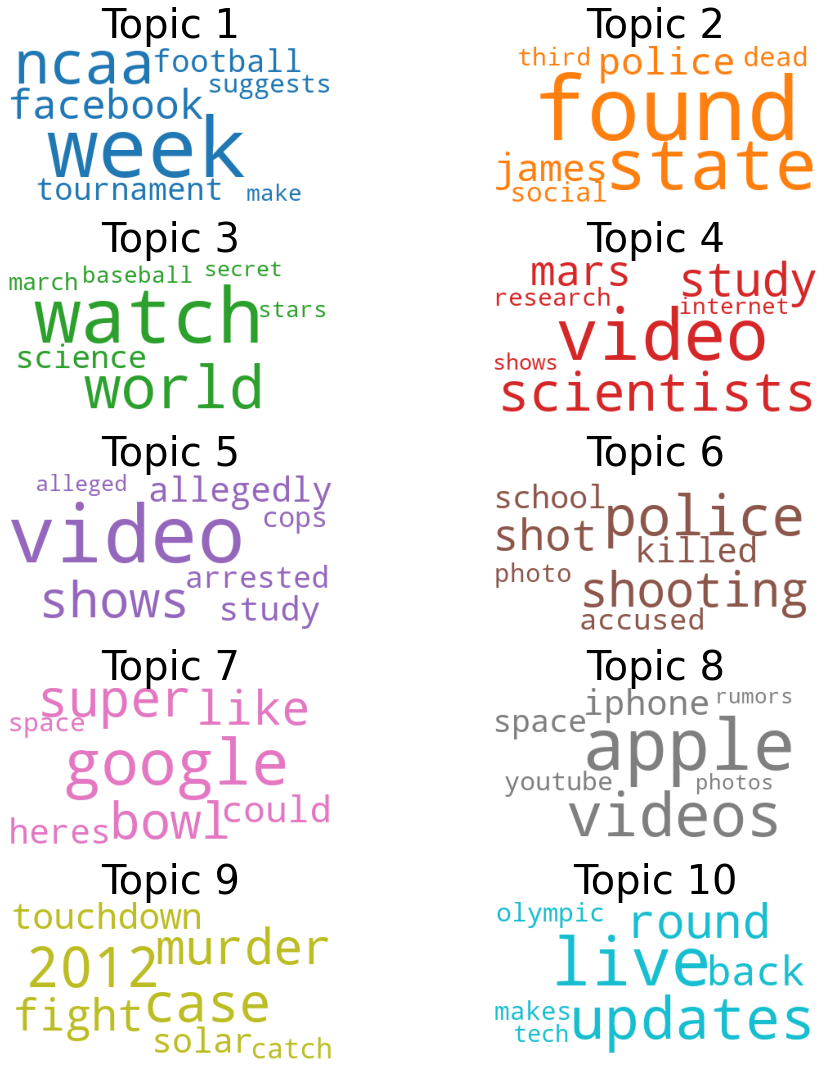

In [111]:
cols = list(mcolors.TABLEAU_COLORS.values())

# Wordcloud of Top N words in each topic with the size of the words proportional to the weight
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  color_func=lambda *_, **kwargs: cols[-num_topics+i],
                  max_words=7,
                  prefer_horizontal=True)

topics = lda_model.show_topics(formatted=False, num_topics=num_topics)
fig, axes = plt.subplots(5, 2, figsize=(15,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().axis('off')
    plt.gca().set_title(f'Topic {i+1}', font=dict(size=40))

plt.tight_layout()
plt.show()